In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, \
                            r2_score, precision_score, f1_score, \
                            recall_score, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy.stats import randint, uniform, loguniform
from sklearn.svm import SVR

In [3]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv('./model_data.csv')

#### Modeling air quality
The pollutant features in this dataset were used to generate the overall air quality metric, which we will be trying to predict based on fire attributes.  The grand motive behind this research question was to define the different impacts of wildfires vs. prescribed fires, to see if there were recommendations for management plans that might reduce unhealthy air quality exposure. After force-merging three uncoordinated datasets, what appeared to be an overwhelming wealth of data condensed down to a comparative handful of useful datapoints.  The plight of many retroactive research questions. Modeling is the weak aspect of this project: this will not yield impressive predictive power nor compelling management suggestions.  In light of that, the following modeling methods are chosen to prioritize inference and shed light on any measureable relationships of features to our target (read: interpretable coefficients).  While we can't forecast the optimal prescribed burn regimen to maximize air quality with these models, hopefully we will validate trends visualized in EDA.

---
'overall_aqi' is an artificially engineered feature, comprising the product of the individual pollutant aqi_measurements.  Thus, all pollutant features are covariates with the target variable.  Actually, more than covariate or collinear with y, they are just _transformations_ of y, so are not valid features for regression.  Spoiler: the pollutants are correlated to the product of the pollutants.

---

The following models explore how to best infer the relationship between air quality and available fire attributes (acreage, wild vs. prescribed, smoke level).

In [5]:
data = data[['state', 'county_name', 'date', 'incid_type', 'burnbndac', 'smoke_score',
            'incid_name', 'event_id', 'overall_aqi', 'any_lat', 'any_lon', 'cluster',
            'class_g', 'yes_fire']].copy()
fmt = '%Y-%m-%d'
data['date'] = pd.to_datetime(data['date'], format=fmt)

In [6]:
# reassign 'Unknown' fires as 'Wildfire'
data.incid_type.value_counts()

No_fire            45433
Wildfire           42296
Prescribed Fire      752
Name: incid_type, dtype: int64

In [7]:
data['incid_type'] = data['incid_type'].map(lambda x: 'Wildfire' if x=='Unknown' else x)

In [8]:
# data.isnull().sum()  #smoke_score has 0.8% nulls, impute with mean
data['smoke_score'] = data['smoke_score'].fillna(np.mean(data['smoke_score']))

In [9]:
data.drop_duplicates(inplace=True)

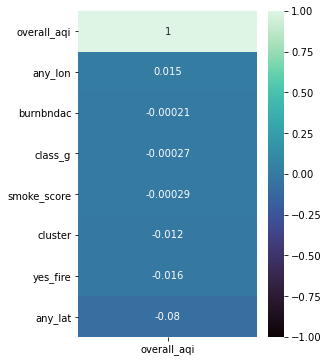

In [10]:
#does not look promising
plt.figure(figsize=(4,6))
corr = data.corr()[['overall_aqi']].sort_values('overall_aqi', ascending=False)
sns.heatmap(corr, cmap='mako', annot=True, vmin=-1, vmax=1);

##### Dummy model

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73479 entries, 0 to 88480
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   state        73479 non-null  object        
 1   county_name  73479 non-null  object        
 2   date         73479 non-null  datetime64[ns]
 3   incid_type   73479 non-null  object        
 4   burnbndac    73479 non-null  float64       
 5   smoke_score  73479 non-null  float64       
 6   incid_name   1929 non-null   object        
 7   event_id     1929 non-null   object        
 8   overall_aqi  73479 non-null  int64         
 9   any_lat      73479 non-null  float64       
 10  any_lon      73479 non-null  float64       
 11  cluster      73479 non-null  int64         
 12  class_g      73479 non-null  int64         
 13  yes_fire     73479 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 8.4+ MB


In [12]:
strip_data = data.drop(['state', 'county_name', 'incid_name', 'event_id', 'any_lat',
                      'any_lon'], axis=1).copy()

In [13]:
strip_data['cluster'] = strip_data['cluster'].astype(str)

In [14]:
strip_data = pd.get_dummies(strip_data, drop_first=True)

In [15]:
#strip_data.info()

In [16]:
X = strip_data.drop(['overall_aqi', 'date'], axis=1)
y = strip_data['overall_aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler() #in linreg scaling changes coefs but not scores...ditch in future
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [17]:
dummy_model = DummyRegressor()
dummy_model.fit(Z_train, y_train)

DummyRegressor()

In [18]:
# dummy_model is as wrong as humanly possible. AND overfit!?
# we can only improve?
dummy_model.score(Z_train, y_train), dummy_model.score(Z_test, y_test)

(0.0, -5.945941827789625e-08)

## By cluster
As seen above, these numeric features do not correlate strongly with our target value at all.  Looking at the data as a whole is misleading, however.  The geographic range of this dataset is expansive, so "large" fires may still register as a relative blip and not be picked up by air quality sensors that are many States away.  To zoom in a bit and see if there are air quality impacts when there is a _nearby_ fire, 32 clusters have been identified through KMeans clustering.  Proximity-based clusters like this are more descriptive than other location identifiers because wildfires don't give a hoot about State and county borders.

In [19]:
#reset
strip_data = data.drop(['state', 'county_name', 'incid_name', 'event_id', 'any_lat',
                      'any_lon'], axis=1).copy()

strip_data = pd.get_dummies(strip_data, drop_first=True) #dummify incid_type
#breakout clusters into separate dfs for modeling
clusters = set(strip_data['cluster'])

df_list = []  #list of 32 x subset dfs

for i in clusters:
    df_list.append(strip_data.loc[strip_data['cluster']==i])

In [20]:
strip_data.overall_aqi.value_counts()

0       68903
1        2872
4        1135
16        517
64         38
25          8
256         4
1024        2
Name: overall_aqi, dtype: int64

In [21]:
 def so_many_lin_regs(df_list):   
    
    count=0
    
    master = []
    
    for i in df_list:
        print(f'start cluster {count}')
        
        info = ['cluster=' + str(count)]
        
        X = i.drop(['date', 'cluster', 'overall_aqi'], axis=1)
        y = i['overall_aqi']
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

        lr=LinearRegression()
        lr.fit(X_train, y_train)
        tr = lr.score(X_train, y_train)
        te = lr.score(X_test, y_test)
        info.append((tr, te))
        
        coefs = pd.Series(lr.coef_, index=X_train.columns)
        coefs = pd.DataFrame(coefs.sort_values(ascending=False).round(4)).rename(columns={0:'coefs'})
        info.append(coefs)
        
        master.append(info)
        count += 1
        
        
    return master    

In [22]:
all_mods1 = so_many_lin_regs(df_list)

start cluster 0
start cluster 1
start cluster 2
start cluster 3
start cluster 4
start cluster 5
start cluster 6
start cluster 7
start cluster 8
start cluster 9
start cluster 10
start cluster 11
start cluster 12
start cluster 13
start cluster 14
start cluster 15
start cluster 16
start cluster 17
start cluster 18
start cluster 19
start cluster 20
start cluster 21
start cluster 22
start cluster 23
start cluster 24
start cluster 25
start cluster 26
start cluster 27
start cluster 28
start cluster 29
start cluster 30
start cluster 31


In [23]:
# top of list entry is 'cluster=X, training R2, testing R2'
all_mods1[16:20]

[['cluster=16',
  (0.0006895089079546057, -0.0038891827052049965),
                               coefs
  incid_type_Wildfire         0.0008
  yes_fire                    0.0004
  burnbndac                   0.0000
  smoke_score                -0.0001
  incid_type_Prescribed Fire -0.0004
  class_g                    -0.0047],
 ['cluster=17',
  (1.0, 1.0),
                              coefs
  burnbndac                     0.0
  smoke_score                   0.0
  class_g                       0.0
  yes_fire                      0.0
  incid_type_Prescribed Fire    0.0
  incid_type_Wildfire           0.0],
 ['cluster=18',
  (0.0010618984310217794, -0.002919934613796471),
                               coefs
  class_g                     0.2681
  incid_type_Wildfire         0.1025
  burnbndac                  -0.0000
  smoke_score                -0.0020
  yes_fire                   -0.1686
  incid_type_Prescribed Fire -0.2711],
 ['cluster=19',
  (0.05371985128528045, 0.02378895761989508),

## Maybe not clusters

Scores are abysmal.  I guess you could say they are overfit, as most test scores are worse than training, but let's be real reducing variance isn't going to cut it.  Some pairs of training/test scores are 1, which has drawn my attention to some clusters having constant AQI scores, meaning 0 sensors were in the region.  They were still clustered as a data-centric zone due to the presence of fires and smoke measurements, but no AQI readings. Even non-constant clusters are just overwhelmed by the 0s, which were long ago imputed to represent 0 reading (and assumed baseline smoke coverage).  Removing 0s now - the equivalent of dropping nulls.  This will absolutely TORCH the amount of data, but since there are no quantifiable relationships in the 'maintain as much data as possible' approach, I'm going for it.   

---

Cluster 19 shows the only semblance of a non-0 or non-negative R2 score and some coefficients that make intuitive sense.  This is an area in southern Arizona that had been identified early in data exploration as having a high amount of data compared to all other regions.  
Next steps
1) Remove 0s and rerun linear regression fits on remaining data
2) Examine cluster 19 specifically

| Cluster | Training R2 | Test R2 | comment                 |
|---------|-------------|---------|-------------------------|
| 19      | 0.05        | 0.02    | not negative, count it! |
| 3       | 1.0         | 1.0     | uh oh                   |
| 5       | 1.0         | 1.0     | dangit                  |
| 6       | 1.0         | 1.0     | oh come on              |

In [24]:
drop_data = strip_data.loc[strip_data['overall_aqi'] != 0].copy()

In [25]:
drop_data.columns

Index(['date', 'burnbndac', 'smoke_score', 'overall_aqi', 'cluster', 'class_g',
       'yes_fire', 'incid_type_Prescribed Fire', 'incid_type_Wildfire'],
      dtype='object')

In [26]:
# now that it's super condensed, run on aggregated data,
# nope still nothing
X = drop_data.drop(['date', 'cluster', 'overall_aqi'], axis=1)
y = drop_data['overall_aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr=LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.00046924591465369314, -0.010985115362505349)

In [27]:
#back to by-cluster, much truncated
clusters = set(drop_data['cluster'])  # down to 16
df_list = []  #list of 32 x subset dfs
for i in clusters:
    df_list.append(strip_data.loc[strip_data['cluster']==i])

In [28]:
clusters

{0, 1, 2, 4, 7, 8, 9, 11, 14, 15, 16, 18, 19, 22, 24, 31}

In [29]:
all_mods2 = so_many_lin_regs(df_list)

start cluster 0
start cluster 1
start cluster 2
start cluster 3
start cluster 4
start cluster 5
start cluster 6
start cluster 7
start cluster 8
start cluster 9
start cluster 10
start cluster 11
start cluster 12
start cluster 13
start cluster 14
start cluster 15


In [30]:
all_mods2

[['cluster=0',
  (0.01960216664907477, 0.01567050744067655),
                               coefs
  incid_type_Wildfire         0.0495
  smoke_score                 0.0143
  burnbndac                  -0.0000
  yes_fire                   -0.0754
  incid_type_Prescribed Fire -0.1249
  class_g                    -0.1594],
 ['cluster=1',
  (0.007484876288346598, 0.0028197121681284854),
                               coefs
  incid_type_Wildfire         0.8766
  yes_fire                    0.8766
  smoke_score                 0.0449
  burnbndac                   0.0004
  incid_type_Prescribed Fire  0.0000
  class_g                    -7.6209],
 ['cluster=2',
  (0.00033628208908875745, -0.000658105975367862),
                               coefs
  yes_fire                    0.0012
  incid_type_Wildfire         0.0012
  incid_type_Prescribed Fire  0.0000
  burnbndac                  -0.0000
  smoke_score                -0.0033
  class_g                    -0.0307],
 ['cluster=3',
  (0.001139

Consistent performance for Cluster 19 since no values dropped.  Clusters with dropped values do not illustrate better performance. Below is SVR on the dataset with all 0 aqi_s dropped; down to ~4000 total observation.  SVR is just to see what happens, there are no justifications for this being a preferred model-type with these data.

In [31]:
# SVM just for fun: battle sword at a teaparty kind of vibe
# only 4000 rows but 0 progress (or verbose output) when run for 11 hours...
svr_pipe=Pipeline([
    ('ss', StandardScaler() ),
    ('svr', SVR() )
])
svr_params= {
    'svr__degree': randint(2,5),
    'svr__C' : loguniform(1e-5, 1e+2),
    'svr__kernel': ['rbf', 'poly']
}

svr = RandomizedSearchCV(estimator=svr_pipe,
                         param_distributions=svr_params, verbose=1,
                         cv=5)

In [32]:
#svr.fit(X_train, y_train)   #fails to converge

In [33]:
# just cluster 19
drop_data = strip_data.loc[strip_data['overall_aqi'] != 0].copy()
just19 = drop_data.loc[drop_data['cluster']==19].copy()

X = just19.drop(['date', 'cluster', 'overall_aqi'], axis=1)
y = just19['overall_aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
svr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('svr', SVR())]),
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x153b2cbb0>,
                                        'svr__degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x153ac1460>,
                                        'svr__kernel': ['rbf', 'poly']},
                   verbose=1)

In [35]:
svr.best_score_  #expected

-0.013080594844301841

In [36]:
svr.best_params_

{'svr__C': 1.1560793260874624, 'svr__degree': 2, 'svr__kernel': 'poly'}